In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator
from pyspark.sql.types import DecimalType, IntegerType, DateType
from pyspark.ml import Pipeline

In [2]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [3]:
df = spark.read.csv('./AirBnb_NYC_2019.csv',header='true',inferSchema='true')

In [4]:
df.head(1)

[Row(id='2539', name='Clean & quiet apt home by the park', host_id='2787', host_name='John', neighbourhood_group='Brooklyn', neighbourhood='Kensington', latitude='40.64749', longitude='-73.97237', room_type='Private room', price='149', minimum_nights='1', number_of_reviews='9', last_review='2018-10-19', reviews_per_month='0.21', calculated_host_listings_count='6', availability_365=365)]

In [5]:
df.select('availability_365').collect()

[Row(availability_365=365),
 Row(availability_365=355),
 Row(availability_365=365),
 Row(availability_365=194),
 Row(availability_365=0),
 Row(availability_365=129),
 Row(availability_365=0),
 Row(availability_365=220),
 Row(availability_365=0),
 Row(availability_365=188),
 Row(availability_365=6),
 Row(availability_365=39),
 Row(availability_365=314),
 Row(availability_365=333),
 Row(availability_365=0),
 Row(availability_365=46),
 Row(availability_365=321),
 Row(availability_365=12),
 Row(availability_365=21),
 Row(availability_365=249),
 Row(availability_365=0),
 Row(availability_365=347),
 Row(availability_365=364),
 Row(availability_365=304),
 Row(availability_365=233),
 Row(availability_365=85),
 Row(availability_365=0),
 Row(availability_365=75),
 Row(availability_365=311),
 Row(availability_365=67),
 Row(availability_365=355),
 Row(availability_365=255),
 Row(availability_365=284),
 Row(availability_365=359),
 Row(availability_365=269),
 Row(availability_365=340),
 Row(availabi

In [6]:
df = df.withColumn("latitude",df["latitude"].cast(DecimalType()))
df = df.withColumn("longitude",df["longitude"].cast(DecimalType()))
df = df.withColumn("price",df["price"].cast(IntegerType()))
df = df.withColumn("minimum_nights",df["minimum_nights"].cast(IntegerType()))
df = df.withColumn("number_of_reviews",df["number_of_reviews"].cast(IntegerType()))
df = df.withColumn("calculated_host_listings_count",df["calculated_host_listings_count"].cast(IntegerType()))
df = df.withColumn("last_review",df["last_review"].cast(DateType()))
df = df.withColumn("reviews_per_month",df["reviews_per_month"].cast(DecimalType()))
df = df.withColumn("availability_365",df["availability_365"].cast(IntegerType()))

In [7]:
df.columns

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [8]:
#creates indexes for each string
indexers = [StringIndexer(inputCol=col, 
                          outputCol=col+'_index',
                         handleInvalid='keep').fit(df) for col in ['neighbourhood_group',
                                                                      'neighbourhood',
                                                                      'room_type']]
pipe = Pipeline(stages=indexers)
df = pipe.fit(df).transform(df)

#creates columns with 0 or 1 for each index
encoder = OneHotEncoderEstimator(inputCols=['neighbourhood_group_index','neighbourhood_index',
                                             'room_type_index'],
                                 outputCols=['neighbourhood_group_dummy','neighbourhood_dummy',
                                             'room_type_dummy'],
                                dropLast=True)
df = encoder.fit(df).transform(df)

df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'decimal(10,0)'),
 ('longitude', 'decimal(10,0)'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'decimal(10,0)'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('neighbourhood_group_index', 'double'),
 ('neighbourhood_index', 'double'),
 ('room_type_index', 'double'),
 ('neighbourhood_group_dummy', 'vector'),
 ('neighbourhood_dummy', 'vector'),
 ('room_type_dummy', 'vector')]

In [9]:
df = df.na.drop()

In [10]:
target = 'price'
features = df.drop('id',
                     'name',
                     'host_id',
                     'host_name',
                     'neighbourhood_group_index',
                     'neighbourhood_index',
                     'room_type_index',
                     'neighbourhood_group',
                     'neighbourhood',
                     'room_type',
                  'price',
                  'last_review').columns

vector = VectorAssembler(inputCols= features,
                         outputCol='features')

vectorized_df = vector.transform(df)
vectorized_df = vectorized_df.select(['features','price'])
vectorized_df.show()

+--------------------+-----+
|            features|price|
+--------------------+-----+
|(552,[0,1,2,3,5,6...|  149|
|(552,[0,1,2,3,5,6...|  225|
|(552,[0,1,2,3,4,5...|   89|
|(552,[0,1,2,3,5,7...|   80|
|(552,[0,1,2,3,4,5...|  200|
|(552,[0,1,2,3,5,8...|   60|
|(552,[0,1,2,3,4,5...|   79|
|(552,[0,1,2,3,4,5...|   79|
|(552,[0,1,2,3,4,5...|  150|
|(552,[0,1,2,3,5,6...|  135|
|(552,[0,1,2,3,4,5...|   85|
|(552,[0,1,2,3,4,5...|   89|
|(552,[0,1,2,3,4,5...|   85|
|(552,[0,1,2,3,5,7...|  120|
|(552,[0,1,2,3,4,5...|  140|
|(552,[0,1,2,3,4,5...|  215|
|(552,[0,1,2,3,4,5...|  140|
|(552,[0,1,2,3,4,5...|   99|
|(552,[0,1,2,3,5,8...|  299|
|(552,[0,1,2,3,4,5...|  130|
+--------------------+-----+
only showing top 20 rows



In [11]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'decimal(10,0)'),
 ('longitude', 'decimal(10,0)'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'decimal(10,0)'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('neighbourhood_group_index', 'double'),
 ('neighbourhood_index', 'double'),
 ('room_type_index', 'double'),
 ('neighbourhood_group_dummy', 'vector'),
 ('neighbourhood_dummy', 'vector'),
 ('room_type_dummy', 'vector')]

In [14]:
train_data, test_data = vectorized_df.randomSplit([.75,.25])

lin_reg = LinearRegression(featuresCol='features', labelCol='price')

model = lin_reg.fit(train_data)

In [21]:
print("R^2 Value: \t",model.summary.r2)
print("RMSE Value: \t",model.summary.rootMeanSquaredError)

R^2 Value: 	 0.15087875033099452
RMSE Value: 	 175.05708128350275


In [22]:
model.coefficients

DenseVector([0.0, 0.0, -0.2778, -0.1984, 0.7499, -0.1219, 0.1898, 21.3751, -9.0486, -21.1071, -28.1347, -31.3271, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.6609, -20.0017, -29.9541, -22.0067, 21.2831, 16.8683, 7.6599, -15.198, -18.9461, 85.1961, 17.9149, -27.4736, 42.0779, 19.782, -10.2195, -57.0211, 63.4442, 31.5452, -26.7076, 47.1763, 5.2367, -24.7278, 14.1587, -19.2224, 16.047, 26.2839, 0.0966, -20.9299, -17.9824, 75.1922, -17.6433, -8.2194, -22.6517, 106.1351, 16.5274, -32.6411, 33.7049, -27.3597, 64.478, 5.2178, 80.5032, -68.0939, 16.3856, -15.7743, 35.1215, -26.5385, -17.4525, -51.8918, -31.8117, -21.4051, 11.1255, 216.9346, -28.5018, -22.5564, -24.9263, 56.8719, 1

In [24]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'decimal(10,0)'),
 ('longitude', 'decimal(10,0)'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'decimal(10,0)'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('neighbourhood_group_index', 'double'),
 ('neighbourhood_index', 'double'),
 ('room_type_index', 'double'),
 ('neighbourhood_group_dummy', 'vector'),
 ('neighbourhood_dummy', 'vector'),
 ('room_type_dummy', 'vector')]

In [23]:
train_data.describe().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             29004|
|   mean|142.16573576058474|
| stddev|189.97756436351492|
|    min|                 0|
|    max|             10000|
+-------+------------------+



In [29]:
import pandas as pd

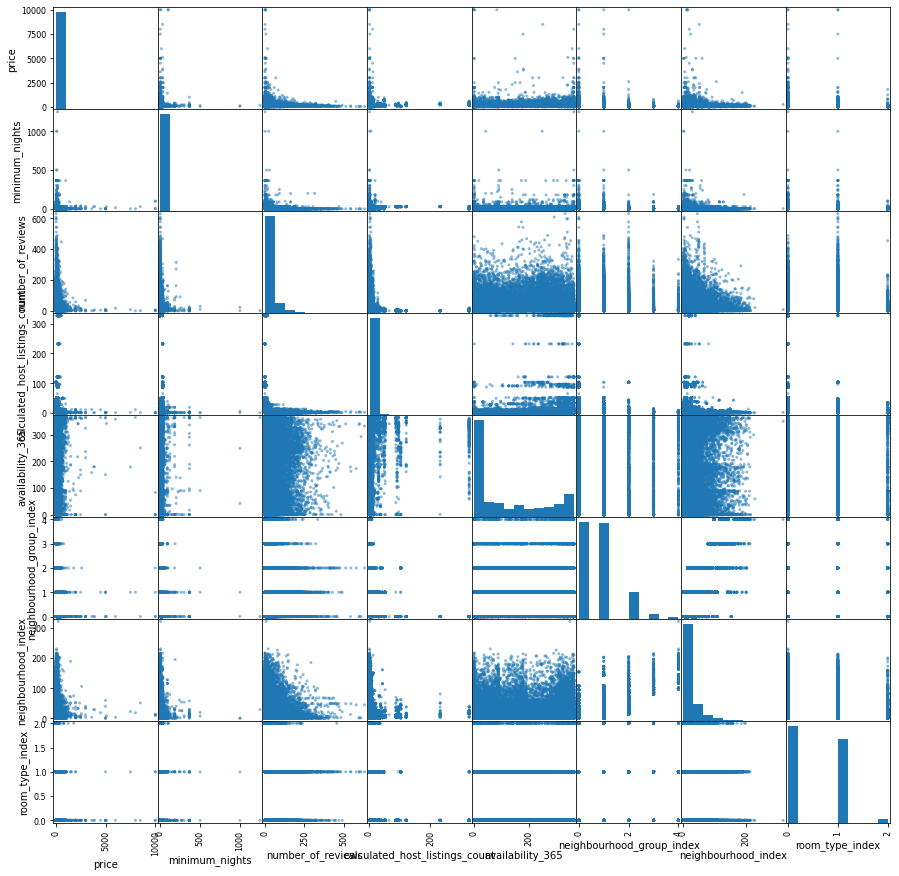

In [33]:
numeric = [col[0] for col in df.dtypes if col[1] in ['int','float','double','decimal(10,0)']]
data_mat = df.select(numeric).toPandas()
pd.plotting.scatter_matrix(data_mat, figsize=(15,15));